# Inflation in Latin America

The data was takes from Kaggle: https://www.kaggle.com/datasets/jaforero/inflation-ipc-in-latam

## Import Libraries

In [1]:
#!pip install category-encoders

In [2]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.impute
import janitor
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import joblib
import warnings

warnings.filterwarnings('ignore')

In [3]:
%run pandas-missing-extension.ipynb

## Upload the dataset to use

In [4]:
df_inflation = pd.read_csv('Inflation.csv')
df_inflation

,País,Año,Link,Fuentes,Inflación Anual
0,Ecuador,2022,https://www.ecuadorencifras.gob.ec//indice-de-...,Banco Ecuador,3.74%
1,El Salvador,2022,http://www.bcr.gob.sv/bcrsite/?x21=73&lang=es,Banco del Salvador,7.32%
2,Panamá,2022,http://www.contraloria.gob.pa/inec/,INEC,2.90%
3,Rep. Dominicana,2022,http://www.bancentral.gov.do/,Banco Central,7.83%
4,Bolivia,2022,https://www.bcb.gob.bo/?q=indicadores_inflacion,Banco Central,3.12%
...,...,...,...,...,...
279,Colombia,2007,http://www.dane.gov.co/,DANE,5.70%
280,Uruguay,2007,http://www.ine.gub.uy/Default.asp,INE,8.50%
281,Brasil,2007,http://www.bcb.gov.br/pec/metas/tabelametasere...,Banco de Brasil,4.50%
282,Argentina,2007,http://www.indec.mecon.ar/nivel4_default.asp?i...,INDEC,8.50%


## EDA

In [5]:
print(df_inflation.shape)

(284, 5)


In [6]:
print(df_inflation.dtypes)

País               object
Año                 int64
Link               object
Fuentes            object
Inflación Anual    object
dtype: object


In [7]:
# Verify if we have null values
df_inflation.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,País,0,284,0.000000
1,Año,0,284,0.000000
2,Link,1,284,0.352113
3,Fuentes,1,284,0.352113
4,Inflación Anual,1,284,0.352113


## Drop the unnecessary column

In [8]:
df_inflation.drop('Link', inplace=True, axis=1)
df_inflation.head()

,País,Año,Fuentes,Inflación Anual
0,Ecuador,2022,Banco Ecuador,3.74%
1,El Salvador,2022,Banco del Salvador,7.32%
2,Panamá,2022,INEC,2.90%
3,Rep. Dominicana,2022,Banco Central,7.83%
4,Bolivia,2022,Banco Central,3.12%


## Transform the columns

In [9]:
# Changing the columns names
df_inflation.columns = ['country', 'year', 'source', 'inflation']

In [10]:
df_inflation.head()

,country,year,source,inflation
0,Ecuador,2022,Banco Ecuador,3.74%
1,El Salvador,2022,Banco del Salvador,7.32%
2,Panamá,2022,INEC,2.90%
3,Rep. Dominicana,2022,Banco Central,7.83%
4,Bolivia,2022,Banco Central,3.12%


**Some countries have white spaces at the end**

In [11]:
df_inflation['country'] = df_inflation['country'].str.strip()

In [12]:
df_inflation['country'].unique()

array(['Ecuador', 'El Salvador', 'Panamá', 'Rep. Dominicana', 'Bolivia',
       'Costa Rica', 'Perú', 'Guatemala', 'Chile', 'Colombia', 'Paraguay',
       'Brasil', 'Nicaragua', 'Honduras', 'México', 'Uruguay',
       'Argentina', 'Venezuela'], dtype=object)

In [13]:
# Create a variable which contains the columns names
encoder = ce.OrdinalEncoder(cols = ['country','source'])

df_inflation_enc = encoder.fit_transform(df_inflation)

In [14]:
df_inflation_enc

,country,year,source,inflation
0,1,2022,1,3.74%
1,2,2022,2,7.32%
2,3,2022,3,2.90%
3,4,2022,4,7.83%
4,5,2022,4,3.12%
...,...,...,...,...
279,10,2007,9,5.70%
280,16,2007,8,8.50%
281,12,2007,11,4.50%
282,17,2007,19,8.50%


In [15]:
df_inflation_enc.head()

,country,year,source,inflation
0,1,2022,1,3.74%
1,2,2022,2,7.32%
2,3,2022,3,2.90%
3,4,2022,4,7.83%
4,5,2022,4,3.12%


In [16]:
df_inflation_enc[['inflation']] = pd.DataFrame(
    ( 
    df_inflation_enc['inflation']
    .astype('str')
    .apply(
        lambda x: x.replace('%', '')
    )
    .astype('float')
)
)

In [17]:
df_inflation_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    284 non-null    int32  
 1   year       284 non-null    int64  
 2   source     284 non-null    int32  
 3   inflation  283 non-null    float64
dtypes: float64(1), int32(2), int64(1)
memory usage: 6.8 KB


## Watching the distributions

<AxesSubplot:>

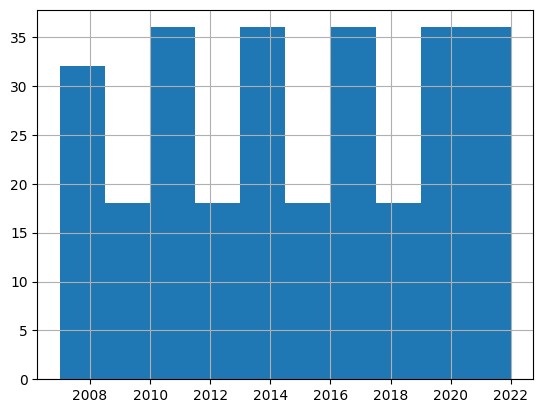

In [18]:
df_inflation_enc['year'].hist()

<AxesSubplot:>

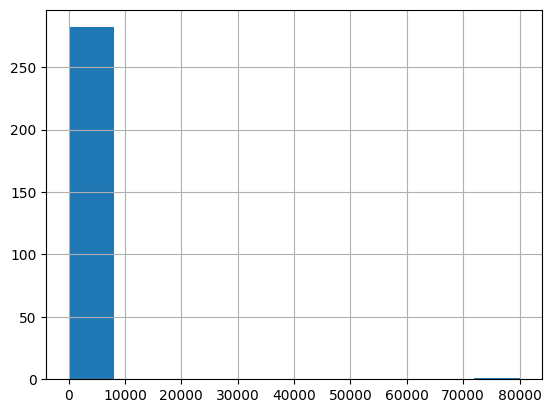

In [19]:
df_inflation_enc['inflation'].hist()

## Adding data with Kmeans

In this case we will group the dataset by year and country

In [20]:
from sklearn.cluster import KMeans
features=['country', 'year']

kmeans = KMeans(n_clusters=4)
kmeans.fit(df_inflation_enc[features])
k_predict = kmeans.predict(df_inflation_enc[features])
df_inflation_enc['clust_by_year_and_country'] = k_predict

  File "C:\Users\TUF GAMER\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


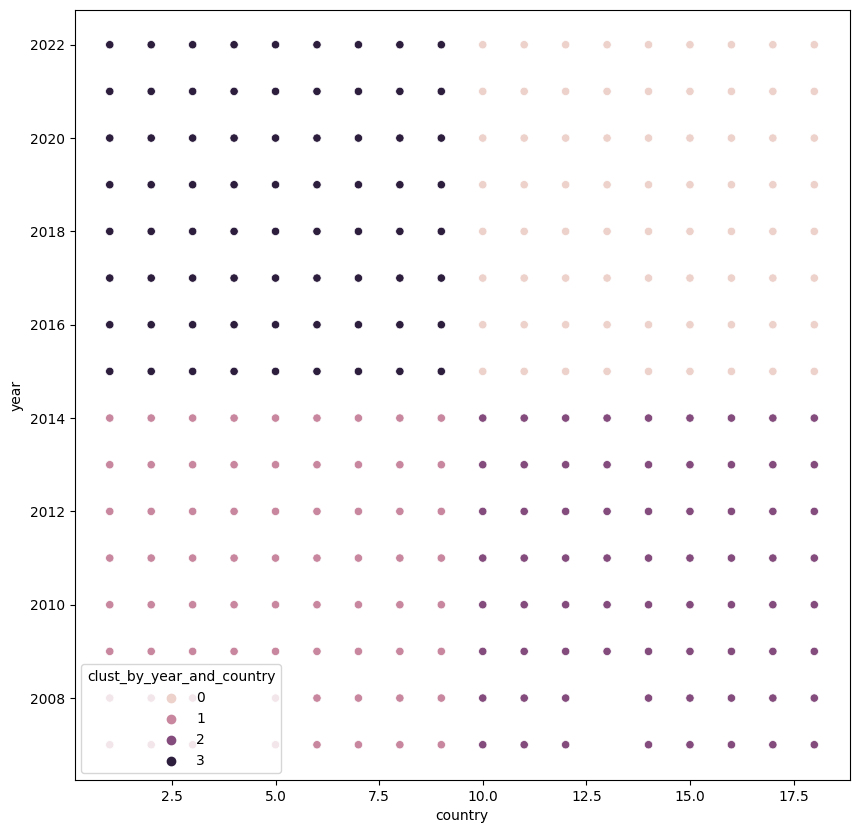

In [21]:
fig = plt.figure(figsize=(10,10))

sns.scatterplot(data=df_inflation_enc, x='country', y='year', hue='clust_by_year_and_country')
plt.plot()
plt.show()

In [22]:
df_inflation_enc

,country,year,source,inflation,clust_by_year_and_country
0,1,2022,1,3.74,3
1,2,2022,2,7.32,3
2,3,2022,3,2.90,3
3,4,2022,4,7.83,3
4,5,2022,4,3.12,3
...,...,...,...,...,...
279,10,2007,9,5.70,2
280,16,2007,8,8.50,2
281,12,2007,11,4.50,2
282,17,2007,19,8.50,2


## Possible Outliers

In [23]:
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers# Driver code
sample_outliers = detect_outliers_zscore(df_inflation_enc['inflation'])
print("Outliers from Z-scores method: ", sample_outliers)

Outliers from Z-scores method:  [80002.0]


## Watching the Distributions

<AxesSubplot:>

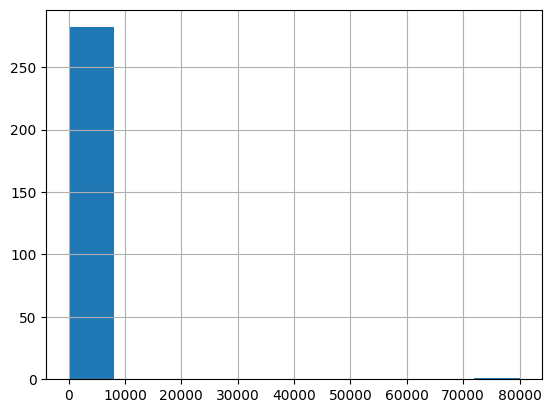

In [24]:
df_inflation_enc['inflation'].hist()

<AxesSubplot:>

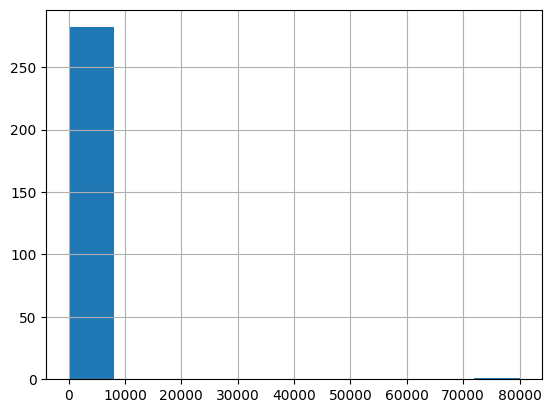

In [25]:
df_inflation_enc['inflation'].hist()

<AxesSubplot:>

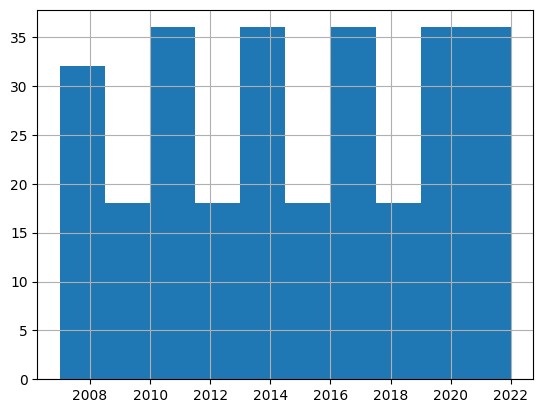

In [26]:
df_inflation_enc['year'].hist()

## Dealing with the NaN values

In [27]:
df_inflation_enc.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,country,0,284,0.000000
1,year,0,284,0.000000
2,source,0,284,0.000000
3,inflation,1,284,0.352113
4,clust_by_year_and_country,0,284,0.000000


In [28]:
df_inflation_enc.dropna(inplace=True)

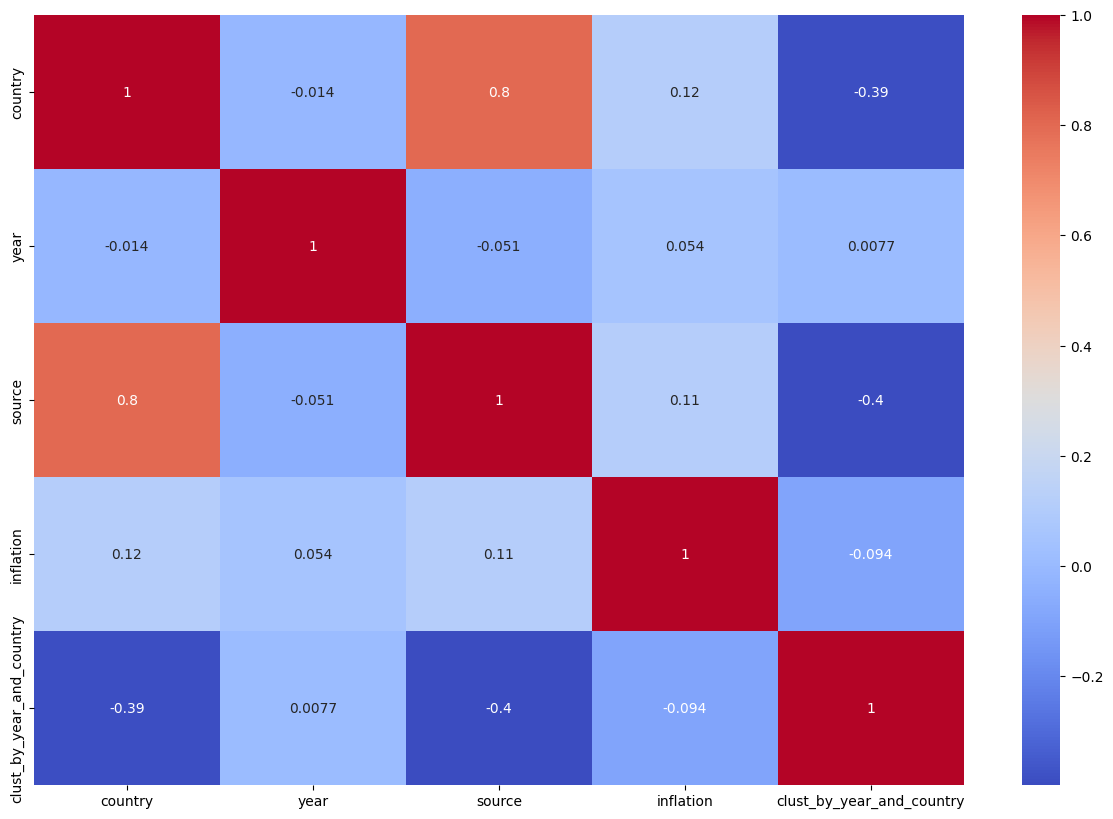

In [29]:
# Let's see the correlation
fig = plt.figure(figsize=(15,10))
sns.heatmap(df_inflation_enc.corr(), annot=True, cmap='coolwarm')
plt.show()

## Pre-procesing of data

In [30]:
# Separate in X and y
X = df_inflation_enc.drop(['inflation'], axis=1)
y = df_inflation_enc['inflation']

In [31]:
# 30% for test and 70% for train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Scaling data

In [32]:
#Scaling numeric features using sklearn StandardScalar
numeric=['year']
sc=MinMaxScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

In [33]:
X_train

,country,year,source,clust_by_year_and_country
273,5,0.000000,4,1
181,3,0.333333,3,1
56,3,0.800000,3,3
113,14,0.600000,13,0
220,4,0.200000,4,1
...,...,...,...,...
189,11,0.333333,10,2
72,1,0.733333,1,3
107,18,0.666667,16,0
271,15,0.000000,14,2


In [34]:
X_test

,country,year,source,clust_by_year_and_country
9,10,1.000000,9,0
247,10,0.133333,9,2
140,16,0.533333,8,0
208,1,0.266667,1,1
76,5,0.733333,4,3
...,...,...,...,...
19,2,0.933333,2,3
118,1,0.600000,1,3
275,11,0.000000,10,2
85,14,0.733333,13,0


## Training the model

In [35]:
# Parameter grid
parameters = {
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': [14],
    'max_features': [1],
    'random_state': [42]
}

clf = GridSearchCV(
    DecisionTreeRegressor(),
    param_grid=parameters,
    scoring='neg_mean_absolute_error',
    cv=10,
    verbose=2
)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_depth=14, max_features=1, random_state=42; total time=   0.0s
[CV] END criterion=squared_error, max_d

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [14], 'max_features': [1],
                         'random_state': [42]},
             scoring='neg_mean_absolute_error', verbose=2)

In [36]:
# Printing the best accuracy and hyperparameters in the model
print("Best hyperparameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)

Best hyperparameters:  {'criterion': 'friedman_mse', 'max_depth': 14, 'max_features': 1, 'random_state': 42}
Best score:  -1216.0433616959065


In [37]:
best_tree_car = clf.best_estimator_
best_tree_car.fit(X_train, y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14, max_features=1,
                      random_state=42)

In [38]:
# Prediction
y_train_pred = best_tree_car.predict(X_train)
y_test_pred = best_tree_car.predict(X_test)

# Print the score
print("MSE of Train data: ", mean_squared_error(y_train, y_train_pred))
print("MSE of Test data: ", mean_squared_error(y_test, y_test_pred))

MSE of Train data:  0.10518728956228957
MSE of Test data:  154.67497728758164


In [39]:
print("R2 of Train data: ", r2_score(y_train, y_train_pred))
print("R2 of Test data: ", r2_score(y_test, y_test_pred))

R2 of Train data:  0.9999999967584893
R2 of Test data:  0.8405496338765693


### The model is overfitting, but with brand new data the perfomance is acceptable

## Storing the model

In [41]:
joblib.dump(best_tree_car, './models/inflation_model.plk')

['./models/inflation_model.plk']